In [1]:
import gc
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
auctions = pd.read_csv('auctions.csv')
clicks = pd.read_csv('clicks.csv')
installs = pd.read_csv('installs.csv')
events = pd.read_csv('events.csv')

c:\users\ignacio\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (12,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
auctions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19571319 entries, 0 to 19571318
Data columns (total 7 columns):
auction_type_id    float64
country            int64
date               object
device_id          int64
platform           int64
ref_type_id        int64
source_id          int64
dtypes: float64(1), int64(5), object(1)
memory usage: 1.0+ GB


In [4]:
auctions.head()

,auction_type_id,country,date,device_id,platform,ref_type_id,source_id
0,NaN,6333597102633388268,2019-03-11 14:18:33.290763,6059599345986491085,1,1,0
1,NaN,6333597102633388268,2019-03-11 14:18:34.440157,1115994996230693426,1,1,0
2,NaN,6333597102633388268,2019-03-11 14:18:35.862360,7463856250762200923,1,1,0
3,NaN,6333597102633388268,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0
4,NaN,6333597102633388268,2019-03-11 14:18:37.728590,1448534231953777480,1,1,0


In [5]:
auctions.isnull().sum()

auction_type_id    19571319
country                   0
date                      0
device_id                 0
platform                  0
ref_type_id               0
source_id                 0
dtype: int64

In [6]:
#dropeo auction_type_id ya que todos sus valores son nulos y country porque todos tienen el mismo valor
auctions.drop(['auction_type_id', 'country'], axis=1, inplace=True)

In [7]:
auctions['date'] = pd.to_datetime(auctions['date'])

In [8]:
print('Rango fechas: ')
print(str(auctions['date'].min()))
print(str(auctions['date'].max()))

Rango fechas: 
2019-03-05 00:52:33.352526
2019-03-13 23:59:59.997032


In [9]:
auctions['day'] = auctions['date'].transform(lambda x : x.day)

In [10]:
auctions['hour'] = auctions['date'].transform(lambda x : x.hour)

Text(0.5, 1.0, 'Correlacion audiciones')

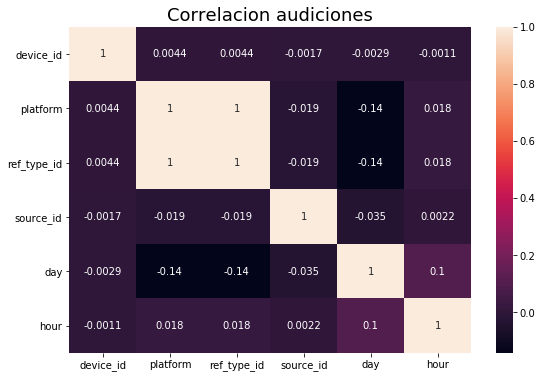

In [11]:
plt.figure(figsize=(9,6))
sns.heatmap(auctions.drop('date', axis=1).corr(), annot=True).set_title('Correlacion audiciones', fontsize=18)

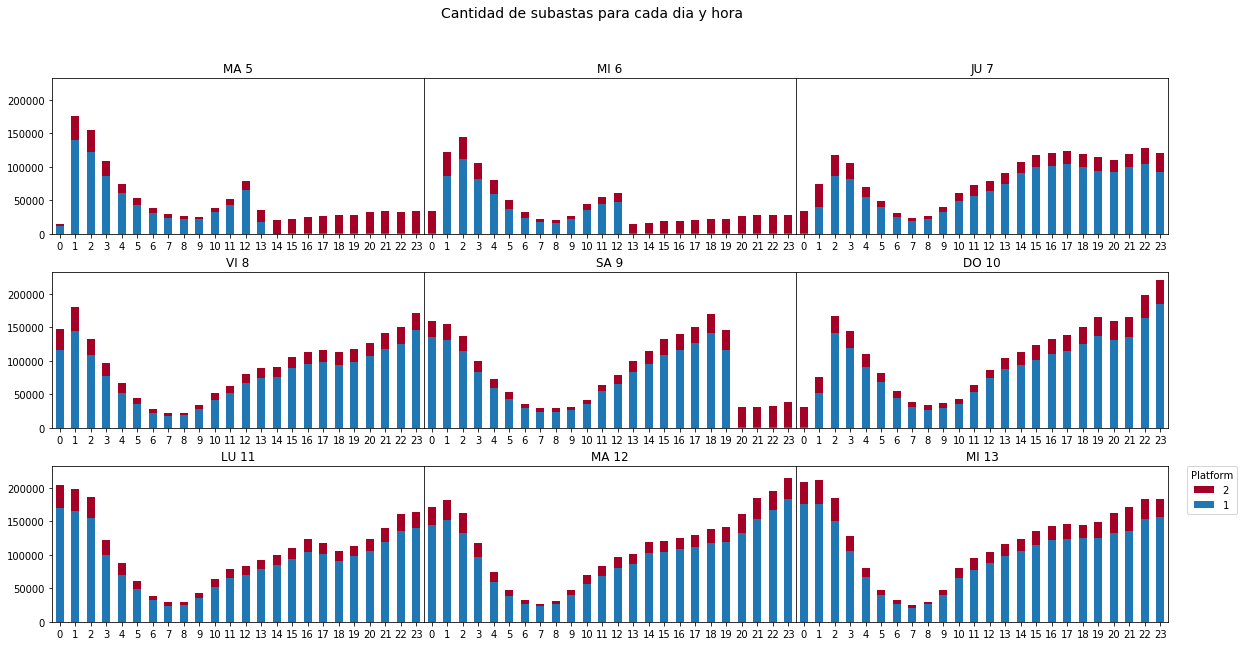

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax = ax.flatten()

fig.suptitle("Cantidad de subastas para cada dia y hora", fontsize=14)
plt.subplots_adjust(wspace=0, hspace=0.25)

diasDeLaSemana = ['LU', 'MA', 'MI', 'JU', 'VI', 'SA', 'DO']

"Para ref_type_id = 7"
for idx, gp in auctions.groupby('day'):
    idx -= 5
    ax[idx].set_title(str(diasDeLaSemana[gp['date'].iloc[0].dayofweek]) + ' ' + str(gp['day'].iloc[0]))
    
    g = gp.groupby(gp['hour']).size().rename_axis([None]).to_frame().reindex(np.arange(0,24,1))\
        .plot(kind='bar', ax=ax[idx], rot=0, legend=False, colormap='RdYlGn')
    
    if idx%3 != 0:
        ax[idx].get_yaxis().set_visible(False)
        
        
"Para ref_type_id = 1"
for idx, gp in auctions[auctions['platform'] == 1].groupby('day'):
    idx -= 5
    
    g = gp.groupby(gp['hour']).size().rename_axis([None]).to_frame().reindex(np.arange(0,24,1))\
        .plot(kind='bar', ax=ax[idx], rot=0, legend=False)
    
    if idx%3 != 0:
        ax[idx].get_yaxis().set_visible(False)

        
lb, ub = list(zip(*[axis.get_ylim() for axis in ax]))
for axis in ax:
    axis.set_ylim(min(lb), max(ub))
    
plt.legend(labels=[2,1],title='Platform', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
plt.show()

In [13]:
auctionsUniqueIDs = auctions['device_id'].unique()
len(auctionsUniqueIDs)

206977

In [14]:
clicksUniqueIDs = clicks['ref_hash'].unique()
len(clicksUniqueIDs)

17119

In [15]:
installsUniqueIDs = installs['ref_hash'].unique()
len(installsUniqueIDs)

3008

In [16]:
interAucCliIDs = np.intersect1d(auctionsUniqueIDs, clicksUniqueIDs)
len(interAucCliIDs)

16979

In [17]:
interAucCliInsIDs = np.intersect1d(interAucCliIDs, installsUniqueIDs)
len(interAucCliInsIDs)

7

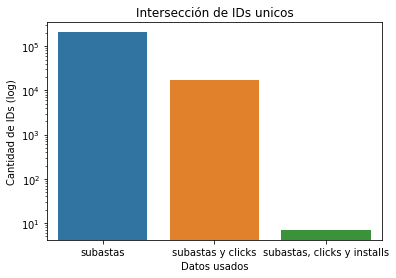

In [18]:
sns.barplot(['subastas','subastas y clicks','subastas, clicks y installs'], [len(auctionsUniqueIDs),len(interAucCliIDs),len(interAucCliInsIDs)])
plt.title('Intersección de IDs unicos')
plt.xlabel('Datos usados')
plt.ylabel('Cantidad de IDs (log)')
plt.yscale('log')

In [19]:
installs['attributed'].value_counts()

False    3412
Name: attributed, dtype: int64

In [20]:
installs[installs['ref_hash'].isin(interAucCliInsIDs)]['implicit'].value_counts()

False    6
True     1
Name: implicit, dtype: int64

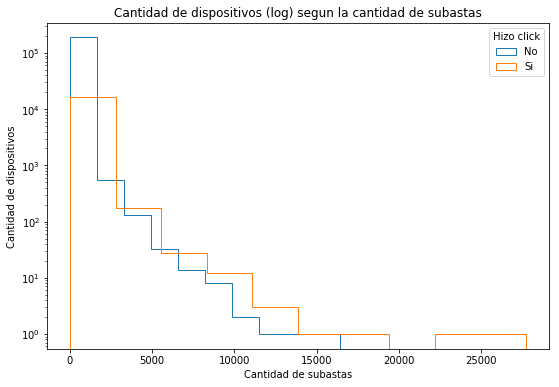

In [21]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9,6)

s = auctions['device_id'].value_counts()
sSoloEnAuctions = s[~s.index.isin(interAucCliIDs)]
sInter = s[s.index.isin(interAucCliIDs)]
plt.hist(sSoloEnAuctions, histtype='step')
plt.hist(sInter, histtype='step')

plt.title('Cantidad de dispositivos (log) segun la cantidad de subastas')
plt.yscale('log')
plt.xlabel('Cantidad de subastas')
plt.ylabel('Cantidad de dispositivos')
plt.legend(['No', 'Si'], title='Hizo click')
plt.show()

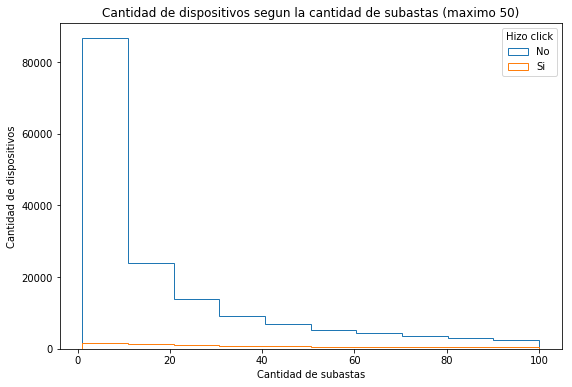

In [22]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9,6)

s = auctions['device_id'].value_counts()
s = s[s <= 100]
sSoloEnAuctions = s[~s.index.isin(interAucCliIDs)]
sInter = s[s.index.isin(interAucCliIDs)]
plt.hist(sSoloEnAuctions, histtype='step')
plt.hist(sInter, histtype='step')

plt.title('Cantidad de dispositivos segun la cantidad de subastas (maximo 50)')
plt.xlabel('Cantidad de subastas')
plt.ylabel('Cantidad de dispositivos')
plt.legend(['No', 'Si'], title='Hizo click')
plt.show()

c:\users\ignacio\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


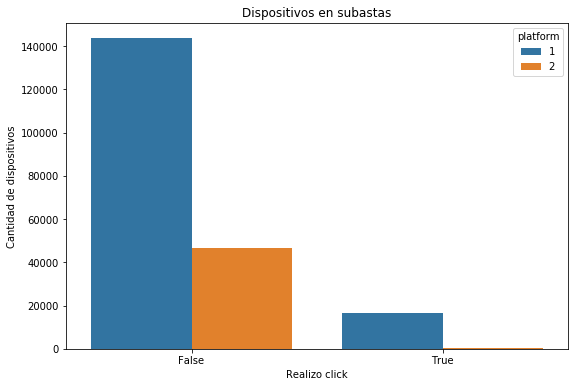

In [23]:
a = auctions.drop_duplicates('device_id')
a['enClicks'] = a['device_id'].isin(interAucCliIDs)
sns.countplot(x='enClicks', hue='platform', data=a)
plt.title('Dispositivos en subastas')
plt.xlabel('Realizo click')
plt.ylabel('Cantidad de dispositivos');

In [24]:
events['date'] = pd.to_datetime(events['date'])

In [25]:
installs['date'] = pd.to_datetime(installs['created'])

In [26]:
gruposInstalls = installs.groupby('ref_hash')['date']

def enIntevaloDeInstall(row):
    dispositivo = row['ref_hash']
    dateEvent = row['date']
    if dispositivo not in gruposInstalls.groups:
        return False
    datesInstallsDispositivo = gruposInstalls.get_group(dispositivo).values
    for dateInstall in datesInstallsDispositivo:
        rangoMenorDate = dateInstall - np.timedelta64(10,'m')
        if rangoMenorDate <= np.datetime64(dateEvent) <= dateInstall:
            return True
    return False

events['enIntervaloDeInstall'] = events.apply(enIntevaloDeInstall, axis=1)

In [27]:
events[events['enIntervaloDeInstall'] == True]['event_id'].value_counts()

22     696
1      231
31      89
80      77
513     40
138     39
161     34
81      34
153     26
162     21
171     17
50       8
164      7
82       6
96       5
157      4
36       4
167      4
98       4
263      3
265      2
272      2
27       2
166      2
188      2
189      2
247      1
273      1
335      1
264      1
121      1
94       1
101      1
113      1
246      1
248      1
400      1
183      1
266      1
Name: event_id, dtype: int64

In [28]:
events['event_id'].value_counts()

22     618228
31     417070
161    217846
1      157812
138    100039
162     84898
329     56490
156     53332
33      48581
171     43942
310     42101
155     38465
273     37056
23      35588
21      26228
98      24301
158     23738
272     22788
80      22076
50      20905
81      18622
346     14408
58      13940
51      13455
513     12682
354     11711
133     11074
256     10939
274     10035
60       9456
        ...  
500         1
511         1
532         1
516         1
132         1
520         1
521         1
523         1
575         1
577         1
578         1
579         1
608         1
433         1
597         1
436         1
589         1
588         1
587         1
586         1
585         1
140         1
583         1
581         1
580         1
437         1
443         1
227         1
226         1
584         1
Name: event_id, Length: 568, dtype: int64